
# Animal Classification Model Creation

This notebook details the creation of a machine learning model that classifies images of animals into domestic animals or predators. It is specifically designed to process images from the North East United States.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import albumentations as Alb
import joblib
from functools import partial
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
%matplotlib inline
AUTO = tf.data.experimental.AUTOTUNE


## Data Preparation

In [2]:

labelImageMap = {}
labels = []
images = []

# Path will be the path containing all of the animal images divided between a domestic and predator folder
path = "newAnimals/"
# Append the two labels into the 'labels' list
with open('binaryTest.txt', 'r') as animalFile:
    for animalType in animalFile:
        labels.append(animalType.strip())

# Obtain the animal images and set them as keys in the dictionary with the value being the label for the image
for label in labels:
    for animalFile in os.listdir(os.path.join(path, label)):
        animalFile = os.path.join(path, label, animalFile)
        images.append(animalFile)
        labelImageMap[animalFile] = label

# Turn the dictionary into a Pandas DataFrame
df = pd.DataFrame(index=labelImageMap.keys(), data=labelImageMap.values())
df.rename(columns={0: 'type'}, inplace=True)
df.index.name = 'id'

# Transform labels to numerical values to make the machine learning algirthms work later
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])


# Create features and target list and split the data into train/test sets
features = df.index
target = df['type']

X_train, X_value, Y_train, Y_value = train_test_split(
    features, target, test_size=0.15, random_state=10)

# Have various forms of our image in training set like the image being flipped or color changed
transforms_train = Alb.Compose([
    Alb.VerticalFlip(p=0.5),
    Alb.HorizontalFlip(p=0.5),
    Alb.CoarseDropout(p=0.7),
    Alb.RandomGamma(p=0.7),
    Alb.RandomBrightnessContrast(p=0.7)
])

# Function albFunction(): The image will be transformed to various forms using the transforms_train variable

def albFunction(img):
    albData = transforms_train(image=img)
    albImg = albData['image']
    return albImg

# Ensures the image goes through the various forms of the image

@tf.function
def process_data(img, lbl):
    albImg = tf.numpy_function(albFunction, [img], Tout=tf.float32)
    return img, lbl


# Function decode_image(): Reads image and resizes it
# Returns a one-hot vector that represents each categorical value in binary format
def decode_image(image_path, label):
    # Read and decode the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # assuming RGB images

    # Resize the image to [224, 224]
    img = tf.image.resize(img, [224, 224])

    # Normalize pixel values to be between 0 and 1
    img = img / 255.0

    return img, label


# Seperate data into training and validation data to ensure our test/validation data does not get looked at in filtered formats
train_data = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_data = (
    tf.data.Dataset
    .from_tensor_slices((X_value, Y_value))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


## Model Creation

In [3]:

# Create a variable containing the pre-trained weight Inception model that is trained with the dataset imagenet.
pre_trained_model = InceptionV3(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# Set the layers.trainable field to False due to us not needing to retrain the Inception model.
for layer in pre_trained_model.layers:
    layer.trainable = False

# The 'mixed7' layer is a clever/special layer that understand many features of an image
mixedSeven = pre_trained_model.get_layer('mixed7')
mixedSevenOutput = mixedSeven.output


# -------------Implement a model using Keras-------------

# flatten the 'mixed7' output into a one-dimensional array to change the layers from being convolutional to fully connected layers in a neural network
arch = layers.Flatten()(mixedSevenOutput)
# Connect each neuron from one layer to the previous layer and perform a weighted sum of its inputs and perform the activation function 'relu'
arch = layers.Dense(512, activation='relu')(arch)
# Normalize the data to ensure the outputs are not too high or not too low
arch = layers.BatchNormalization()(arch)
arch = layers.Dense(256, activation='relu')(arch)

# Prevent overfitting by dropping 30% of the neurons. This ensures that our model doesn't rely too much on specific features in the training set
arch = layers.Dropout(0.3)(arch)
arch = layers.BatchNormalization()(arch)
# Create the final output of the layers by converting all of the neurons into probabilistic scores
output = layers.Dense(1, activation='sigmoid')(arch)
model = keras.Model(pre_trained_model.input, output)

# Configure the learning process of the model
# 'optimizer' is the algorithm of choice to update model weights when training.
# 'loss' is the objective function that the model is trying to minimize while training. Our choice is typically used for multi-class classification tasks.
# 'metrics' is the metric that will be evaluated by the model during the training and testing process
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training the Model

In [4]:
# A way to stop the training process due to the validation accuracy reaching a point where the model is working well
class modelCallback(tf.keras.callbacks.Callback):
    def epoch_end(self, epoch, hist={}):
        if hist.get('val_accuracy') > 0.99:
            print(
                '\nValidation accuracy has reached upto 90%\ so, stopping further training.')
            self.model.stop_training = True


# Stops the training accuracy if there's no sign of the validation accuracy improving to stop it from possibly getting slightly worse
earlyStop = EarlyStopping(
    patience=5, monitor='val_accuracy', restore_best_weights=True)

# Reduces the learning rate during training if the validation loss metric is not improving
learingRate = ReduceLROnPlateau(
    monitor='val_loss', patience=2, factor=0.5, verbose=1)

# Trains the model
trained = model.fit(train_data, validation_data=val_data, epochs=10,
                    verbose=1, callbacks=[earlyStop, learingRate, modelCallback()])


Epoch 1/10


60/60 [==============================] - 49s 748ms/step - loss: 0.3585 - accuracy: 0.8482 - val_loss: 0.2108 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - 43s 720ms/step - loss: 0.0452 - accuracy: 0.9890 - val_loss: 0.1744 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 3/10
60/60 [==============================] - 43s 713ms/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.1357 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 4/10
60/60 [==============================] - 43s 711ms/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 0.1323 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 5/10
60/60 [==============================] - 43s 707ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1436 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 6/10
60/60 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
60/60 [==============================] - 43s 708

## Training Plots

<Axes: >

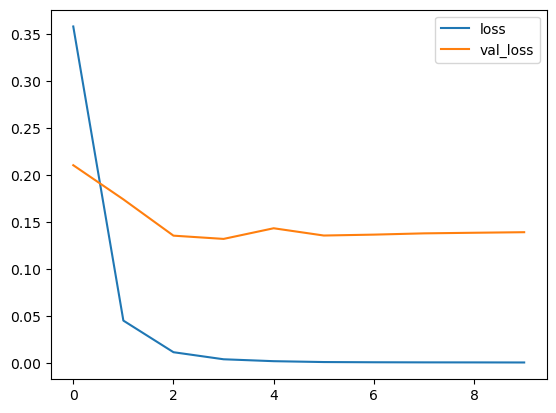

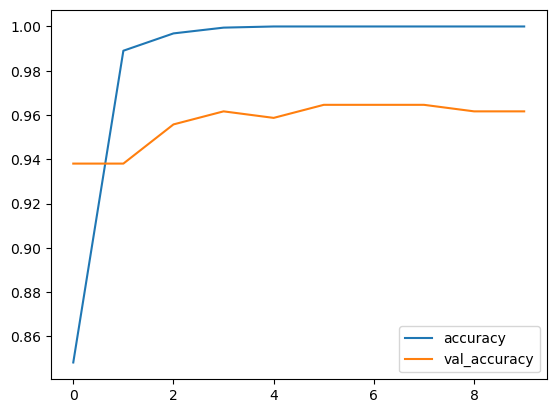

In [5]:
# Obtain the history of the training process and turn it into a Pandas DataFrame.
# Uses the history to create two curve plots: loss/val_loss and accuracy/val_accuracy
trainedDf = pd.DataFrame(trained.history)
trainedDf.loc[:, ['loss', 'val_loss']].plot()
trainedDf.loc[:, ['accuracy', 'val_accuracy']].plot()

## Process Unseen Data

In [6]:
def preprocess_unseen_data(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    if img.shape[-1] > 3:
        img = img[:, :, :3]
    return img

def make_predictions(model, data):
    predictions = model.predict(data)
    return predictions

def post_process_predictions(predictions, encoder):
    predicted_labels = (np.max(predictions, axis=1) >= .50).astype(int)
    predicted_labels = encoder.inverse_transform(predicted_labels)
    return predicted_labels

#list of file paths for unseen data
unseen_path_name = 'unseen-images/'
unseen_data_paths = [os.path.join(unseen_path_name, file) for file in os.listdir(unseen_path_name)]

unseen_data = [preprocess_unseen_data(path) for path in unseen_data_paths]
unseen_data_tensor = tf.stack(unseen_data)

# Make predictions
predictions = make_predictions(model, unseen_data_tensor)
predicted_labels = post_process_predictions(predictions, encoder)
predicted_probabilities = np.max(predictions, axis=1)
print(predicted_probabilities)

for i in range(len(predicted_probabilities)):
    if predicted_probabilities[i] < 0.50:
        predicted_probabilities[i] = 1 - predicted_probabilities[i]

for data_path, label, probability in zip(unseen_data_paths, predicted_labels, predicted_probabilities):
    print(
        f"Image: {data_path}, Predicted Label: {label}, Probability: {probability:.4f}")
        

1/1 [==============================] - 1s 981ms/step
[4.8012126e-04 7.1757427e-06 9.6995669e-04 9.8838401e-01]
Image: unseen-images/image1.jpg, Predicted Label: domestic, Probability: 0.9995
Image: unseen-images/image19.jpg, Predicted Label: domestic, Probability: 1.0000
Image: unseen-images/image270.jpg, Predicted Label: domestic, Probability: 0.9990
Image: unseen-images/image371.jpg, Predicted Label: predator, Probability: 0.9884


## Plotting Predictions

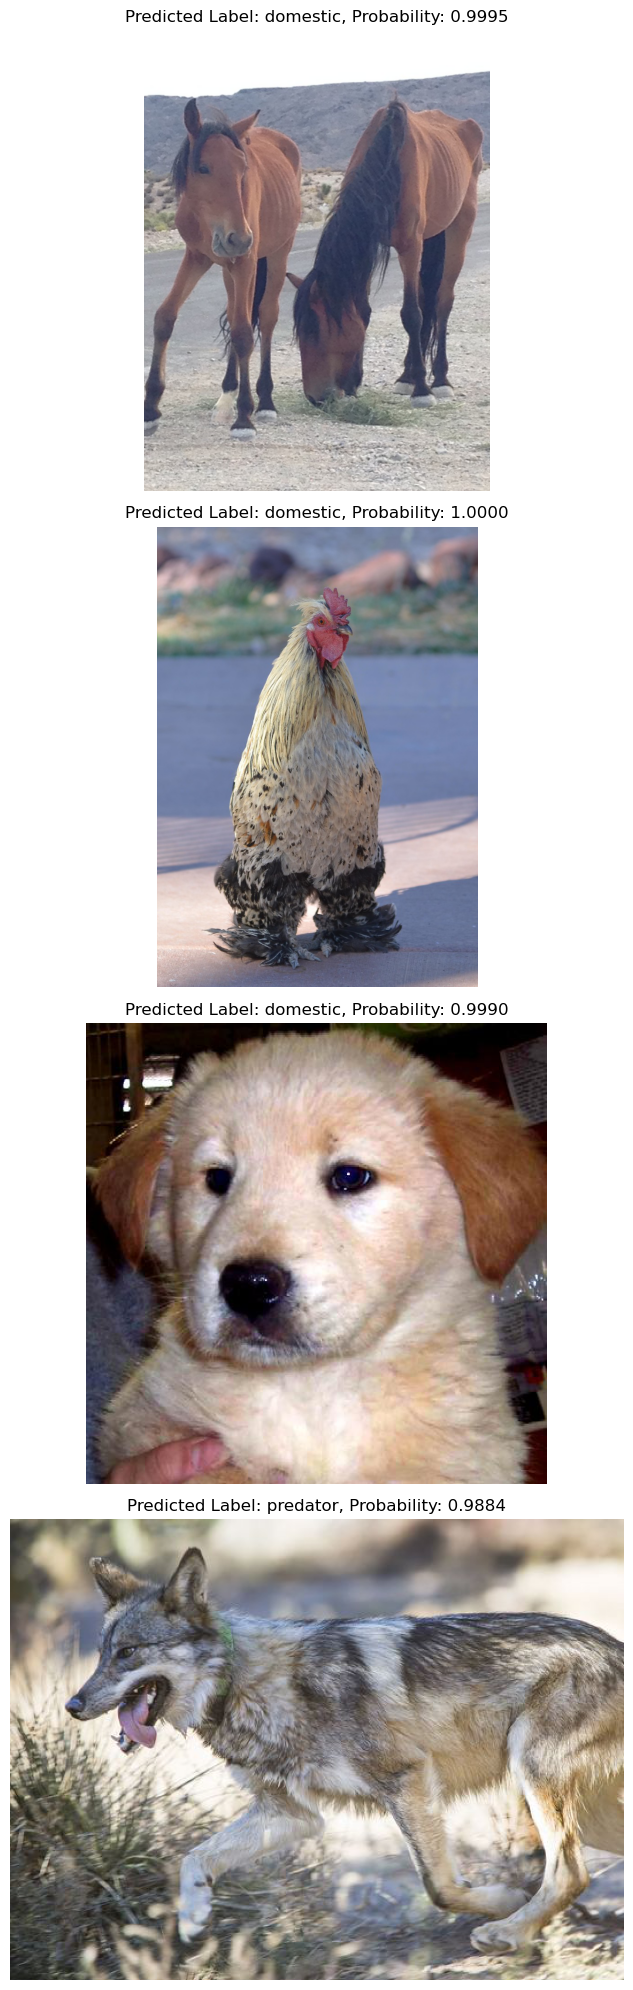

In [7]:
# Plotting
fig, axs = plt.subplots(len(unseen_data_paths), 1, figsize=(10, len(unseen_data_paths) * 5))
if len(unseen_data_paths) == 1:
    axs = [axs]

for ax, data_path, label, probability in zip(axs, unseen_data_paths, predicted_labels, predicted_probabilities):
    img = plt.imread(data_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Predicted Label: {label}, Probability: {probability:.4f}", fontsize=12)

plt.tight_layout()
plt.show()